In [1]:
import matplotlib
import sys
import gc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import FormatStrFormatter
import scipy.stats
import scipy.optimize


# Para manejar los archivos y automatizar la lectura en directorios
import csv
import os
# Fontsize
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
# Latex font
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
%matplotlib inline

# Nombres de archivo, paths y definiciones

In [2]:
# SOME DEFINITIONS
# Level of the simulation ('_' for filename format)
lvl = 'Level 4/level4_'
# number of halos
nhalos = 30 

'''# level of the simulation
lvl = 'Level 3/level3_'
# number of halos
nhalos = 6''' 

# FOLDER CONTAINING ALL FILES
folder = '../Data/Halo_General/'

# FILENAMES
# Contains parameters of the disk (MHD)
fn_params = lvl+'params'+'.csv'
# Triaxial eigensystem different radii (MHD & DM) using volumetric (mean) density: Allgood et al.
fn_axes = lvl+'axes'+'.csv' # Axes = axial ratios (sqrt of eigenvals)
fn_vecs = lvl+'vecs'+'.csv' # Vecs = principal axes directions

# Definicion de funciones

In [3]:
# Reads file in "path/filename"
# Returns data as a numpy array
# Returns filenames as a list of strings
# Returns headers as an array of strings

def read_csv(filename,skip_header=1):

    # Removes quotations from file (little writing error) 
    os.system('sed -i \'s/"//g\' '+filename) 
    
    # FILENAMES!
    headers = []
    with open( filename , 'r') as myfile:
        rd = csv.reader(myfile)
        headers = next(rd) # gets only first line 
    
    data = np.genfromtxt(filename, delimiter = ',', skip_header=skip_header, dtype=float )
    
    return headers,data


# Obteniendo los datos

## Virial Radius

In [4]:
# The virial radius R200
import pandas as pd
Rvir200 = pd.read_csv('../Data/Halo_General/RVir200.csv')
Rvir200.keys()

Index(['DM', 'MHD'], dtype='object')

# Closest radii to Rvir found for lvl 4MHD and DM
Radii compraison and percent error

In [5]:
from scipy.stats.mstats import gmean

# Se define el nivel al cual se obtendran las graficas
#lvl = 'level3'
lvl = 'level4'

# Los niveles tienen un conjunto distinto de halos
halonums = None
if lvl == 'level3':
    halonums = [6,16,21,23,24,27]
if lvl == 'level4':
    halonums = range(1,31)

# Measurements near rvir    
axes_vir_MHD = np.loadtxt("../Data/Halo_Detail/"+lvl+"_MHD/"+"Semiaxes_rvir_1e2rvir.csv", delimiter = ',')[:,:3]
radsvMHD = gmean(axes_vir_MHD,axis = 1)

axes_Rvir_MHD = []
axes_Rvir_DM = []

# Recorre los halos para encontrar la diferencia entre el radio virial 
# y el radio sampleado mas cercano
for i in halonums:
    # Obtiene el nombre de la carpeta para el halo especifico
    # The difference
    print("-------------- halo "+str(i)+"---------------------")
    halo = 'halo_'+str(i)
    # Consulta los semiejes de DM y MHD
    arrDM = np.loadtxt("../Data/Halo_Detail/"+lvl+"_DM/"+halo+"/"+"abc_"+lvl+"_DM_"+halo+".txt", delimiter = ',')
    # The list of all radii sampled
    radsDM = gmean(arrDM,axis = 1)
    # The minimum difference
    argminDM = np.argmin(np.abs(radsDM-Rvir200['DM'][i-1]))
    axes_Rvir_DM.append(arrDM[argminDM])
    print('DM: ', Rvir200['DM'][i-1],radsDM[argminDM],100*abs(Rvir200['DM'][i-1]-radsDM[argminDM])/Rvir200['DM'][i-1])

    if i != 20 and i != 19:
        # Consulta los semiejes de DM y MHD
        arrMHD = np.loadtxt("../Data/Halo_Detail/"+lvl+"_MHD/"+halo+"/"+"abc_"+lvl+"_MHD_"+halo+".txt", delimiter = ',')
        arrMHD = np.loadtxt("../Data/Halo_Detail/"+lvl+"_MHD/"+halo+"/"+"abc_"+lvl+"_MHD_"+halo+".txt", delimiter = ',')

        # The list of all radii sampled
        radsMHD = gmean(arrMHD,axis = 1)
        # The minimum difference
        argminMHD = np.argmin(np.abs(radsMHD-Rvir200['MHD'][i-1]))
        axes_Rvir_MHD.append(arrMHD[argminMHD])
        print('MHD: ',Rvir200['MHD'][i-1],radsMHD[argminMHD],100*abs(Rvir200['MHD'][i-1]-radsMHD[argminMHD])/Rvir200['MHD'][i-1])
    else: 
        axes_Rvir_MHD.append(axes_vir_MHD[i-1])
        print('MHD: ',Rvir200['MHD'][i-1],radsvMHD[i-1],100*abs(Rvir200['MHD'][i-1]-radsvMHD[i-1])/Rvir200['MHD'][i-1])


-------------- halo 1---------------------
DM:  196.92700000000002 193.91779537311618 1.5280812823451546
MHD:  187.674 194.29879795962833 3.5299497850678967
-------------- halo 2---------------------
DM:  235.09400000000002 228.8256542667573 2.6663146372271136
MHD:  233.93400000000003 218.54863346732265 6.576797956978199
-------------- halo 3---------------------
DM:  210.69299999999998 223.67077999197497 6.159568657703382
MHD:  210.955 207.80203888126277 1.4946131254235444
-------------- halo 4---------------------
DM:  219.378 204.42155914128077 6.817657585865137
MHD:  215.438 225.89128537205852 4.852108435864857
-------------- halo 5---------------------
DM:  196.984 192.3176582992171 2.3688937684192157
MHD:  197.24599999999998 208.99668048343622 5.957373271669002
-------------- halo 6---------------------
DM:  191.84 185.36191840769996 3.376814841691015
MHD:  189.342 178.53169895475946 5.709404699031672
-------------- halo 7---------------------
DM:  197.864 197.89437121420153 0.01

In [6]:
# Obtiene el contenido del archivo de semiejes
headers,axes = read_csv(folder+fn_axes)
print(headers)
# Obtiene el contenido del archivo de vctores propios asociados
headers,vecs = read_csv(folder+fn_vecs)

['a12', 'b12', 'c12', 'a25', 'b25', 'c25', 'a50', 'b50', 'c50', 'a1', 'b1', 'c1', 'aDisk', 'bDisk', 'cDisk']


### Formato de archivo
\n
<font size=3>
En el archivo de semiejes, la primera letra es el semieje correspondiente $a>b>c$
Los caracteres consecutivos indican el radio en el que fue caracterizada la forma:
</font>

*  $12 \equiv 12.5\%\ R_{vir}$ 
*  $25 \equiv 25\%\ R_{vir}$ 
*  $50 \equiv 50\%\ R_{vir}$ 
*  $100 \equiv 100\%\ R_{vir}$ 
*  $Disk \equiv Sampleado\ en\ el\ disco\ estelar$ 

\
<font size=3>
Adicionalmente, en terminos de filas, el archivo muestra los ejes de los halos MHD y DM intercalados de la siguiente manera:
</font>

*  --------Header------------
*  ----Info Halo1 MHD----
*  ----Info Halo1  DM------
*  ----Info Halo2 MHD----
*  ----Info Halo2  DM------
*        -------------...--------------

\

<font size=3>
Para el archivo de vectores de ejes principales el formato sigue la misma logica
</font>


In [7]:
# Dado el formato del archivo explicado anteriormente
# Se obtienen los resultados en terminos de arrays

# RADII SAMPLED
rad_sampl = ['12.5%Rvir500'
            ,'25%Rvir500'
            ,'50%Rvir500'
            ,'100%Rvir500'
            ,'100%Rvir200'
            ,'Stellar Disk']

# AXES
axes = np.reshape(axes,(2*nhalos,5,3)) # contains DM and MHD (2*nhalos) axes (3) sampled at (5) radii
axesMHD = axes[::2] #organized halo1MHD,halo1DM,halo2MHD,halo2DM....
axesMHD = np.insert(axesMHD,4,axes_Rvir_MHD,axis=1)
axesDM = axes[1::2]
axesDM = np.insert(axesDM,4,axes_Rvir_DM,axis=1)

# indices > haloid, rad_sampled, axis id

# VECS
vecs = np.reshape(vecs,(2*nhalos,5,3,3)) # contains DM and MHD (2*nhalos) vecs (3,3) sampled at (5) radii
vecsMHD = vecs[::2]
vecsDM = vecs[1::2]

# indices > haloid, rad_sampled, axis id, vector component

## El plano de triaxialidad

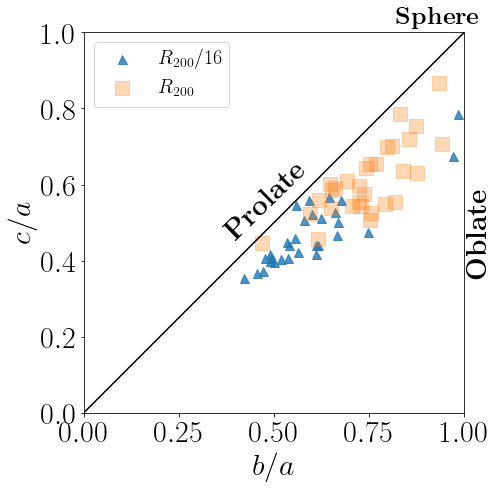

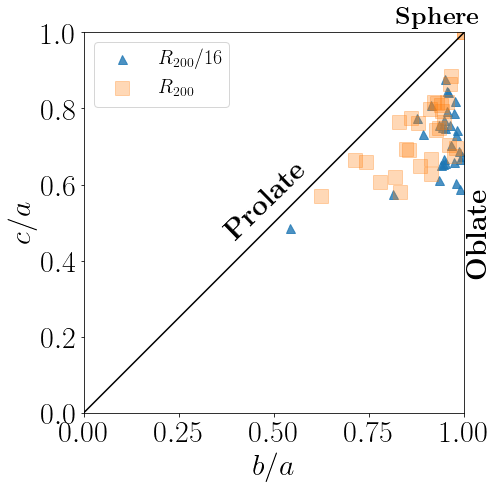

In [272]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
for axe,name in (zip([axesDM,axesMHD],['DM','MHD'])):
    # for the table (PAPER)
    summary = np.array([axe[:,:,1]/axe[:,:,0], axe[:,:,2]/axe[:,:,0]])
    mean = np.percentile(summary,50,axis=1)
    std1  = np.percentile(summary,84,axis=1)-mean
    std2  = mean - np.percentile(summary,16,axis=1)
    tostr = lambda arr,s1,s2: ['%1.2f^{+%.2f}_{-%.2f}'%(arr[i],s1[i],s2[i]) for i in range(len(arr))]
    #print(summary)
    # Fonts 
    MEDIUM_SIZE = 30
    SMALL_SIZE = 30
    SSSMALL_SIZE = 16

    plt.rc('font', size=SSSMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels


    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111,aspect='equal')

    ax.plot(summary[0,:,0],summary[1,:,0],'^',markersize=9,label= r"$R_{200}/16$", alpha=0.8) # 1/8 R 
   # ax.errorbar(mean[0,0],mean[1,0],fmt='o', color='crimson' ,xerr=[[std1[0,0],std2[0,0]]],yerr=[[std1[1,0],std2[1,0]]])  
    ax.plot(summary[0,:,-2],summary[1,:,-2],'s',markersize=14,label= r"$R_{200}$", alpha=0.3) # 1 R
    #ax.errorbar(mean[0,-2],mean[1,-2],fmt='s',color='darkblue',xerr=[[std1[0,-2],std2[0,-2]]],yerr=[[std1[1,-2],std2[1,-2]]])



    ax.set_xlim(0,1)
    ax.set_ylim(0,1)

    # Rotate angle
    angle_pro = 45
    pos_pro = np.array([0.4,0.45])
    trans_angle_pro = ax.transData.transform_angles(np.array((angle_pro,)),
                                                       pos_pro.reshape((1, 2)))[0]

                                                       # Rotate angle
    angle_ob = 90
    pos_ob = np.array([1.06,0.35])
    trans_angle_ob = ax.transData.transform_angles(np.array((angle_ob,)),
                                                       pos_ob.reshape((1, 2)))[0]
    # Plot text
    prolate = ax.text(pos_pro[0],pos_pro[1], '\\textbf{Prolate}', fontsize=SMALL_SIZE-2,
               rotation=trans_angle_pro, rotation_mode='anchor')
    # Plot text
    oblate = ax.text(pos_ob[0],pos_ob[1], '\\textbf{Oblate}', fontsize=SMALL_SIZE-2,
               rotation=trans_angle_ob, rotation_mode='anchor')

    # Plot text
    sphere = ax.text(0.82,1.02
    , '\\textbf{Sphere}', fontsize=SMALL_SIZE-5)           



    ax.set_xlabel(r"$b/a$")
    ax.set_ylabel(r"$c/a$")

    ax.plot([0,1],[0,1],color='black')
    plt.legend(loc=0, fontsize=20)
    #plt.show()
    plot_name = '../Document/Lvl_4_Triax_Plane_'+name+'.pdf'
    plt.savefig(plot_name,bbox_inches='tight')

[[0.9360842  0.92451054 0.91024703 0.89514462 0.89127518 0.90942549]
 [0.71447468 0.71578139 0.72356913 0.72812108 0.74204885 0.72010605]]


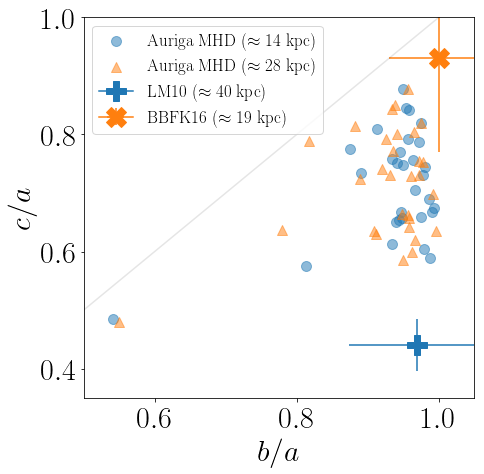

In [267]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# for the table (PAPER)
summary = np.array([axe[:,:,1]/axe[:,:,0], axe[:,:,2]/axe[:,:,0]])
mean = np.mean(summary, axis=1)
std  = np.std(summary, axis=1)
print(mean)
#print(summary)
# Fonts 
MEDIUM_SIZE = 30
SMALL_SIZE = 30
SSSMALL_SIZE = 16

plt.rc('font', size=SSSMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels

fig = plt.figure(figsize=(7,7))
#ax = fig.add_subplot(111,aspect='equal')

i_radius = 0
plt.scatter(summary[0,:,i_radius],summary[1,:,i_radius],
            marker='o',s=100,
             label= r"${\rm Auriga\ MHD}\ (\approx 14\ {\rm kpc})$", 
             alpha=0.5) # 

i_radius = 1
plt.scatter(summary[0,:,i_radius],summary[1,:,i_radius],
            marker='^',s=100,
             label= r"${\rm Auriga\ MHD}\ (\approx 28\ {\rm kpc})$", 
             alpha=0.5) # 

#i_radius = 1
#plt.errorbar(mean[0,i_radius],mean[1,i_radius],
#            std[0,i_radius], std[1,i_radius], 
#            marker='o',markersize=20,
#             label= r"${\rm This\ work}\ \ \ (25\ {\rm kpc})$", 
#             alpha=0.5, color='black') # 

#i_radius = 2
#plt.errorbar(mean[0,i_radius],mean[1,i_radius],
#            xerr=std[0,i_radius], yerr=std[1,i_radius], 
#            marker='^',markersize=20,label= r"${\rm This\ work}\ \ \ (50\ {\rm kpc})$", 
#             alpha=0.5, color='black') 


#illustris_q = 0.87
#illustris_s = 0.70
#plt.errorbar(illustris_q,illustris_s,xerr=0.1,yerr=0.1, 
#            marker='s',markersize=15,label= r"${\rm Illustris}\ \ \ (30\ {\rm kpc})$", 
#             alpha=1.0, color='black') 


lm10_q = 0.97
lm10_q_sigma = 0.097
lm10_s = 0.44
lm10_s_sigma = 0.044
plt.errorbar(lm10_q, lm10_s, xerr=lm10_q_sigma, yerr=lm10_s_sigma, 
            marker='P',markersize=20,label= r"${\rm LM10}\ (\approx 40\ {\rm kpc})$", 
             alpha=1.0)

bovy_q = 1.0
bovy_q_sigma = 0.07
bovy_s = 0.93
bovy_s_sigma = 0.16
plt.errorbar(bovy_q, bovy_s, xerr=bovy_q_sigma, yerr=bovy_s_sigma, 
            marker='X',markersize=20,label= r"${\rm BBFK16}\ (\approx 19\ {\rm kpc})$", 
             alpha=1.0)
x = np.linspace(0.5, 1.0, 10)
plt.plot(x,x,color='black', alpha=0.1)

plt.xlim(0.5,1.05)
plt.ylim(0.35,1.00)

plt.xlabel(r"$b/a$")
plt.ylabel(r"$c/a$")

#ax.plot([0,1],[0,1],color='black')
plt.legend(loc=2, fontsize=17)
#plt.show()
plot_name = '../Document/triaxiality_observations.pdf'
plt.savefig(plot_name,bbox_inches='tight')

In [147]:
print(np.shape(summary[:,:,:]))

(2, 30, 6)


In [32]:
axis_a = axesDM[:,:,0]
axis_b = axesDM[:,:,1]
axis_c = axesDM[:,:,2]
T_DM = (axis_a**2-axis_b**2)/(axis_a**2-axis_c**2)

axis_a = axesMHD[:,:,0]
axis_b = axesMHD[:,:,1]
axis_c = axesMHD[:,:,2]
T_MHD = (axis_a**2-axis_b**2)/(axis_a**2-axis_c**2)


i_radius_vir_8 = 0 
i_radius_vir = -2
ii_nan = np.isnan(T_MHD)
T_MHD[ii_nan] = 0.01

delta_T = (T_MHD-T_DM)

#print(T_MHD.min())

/Users/forero/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide


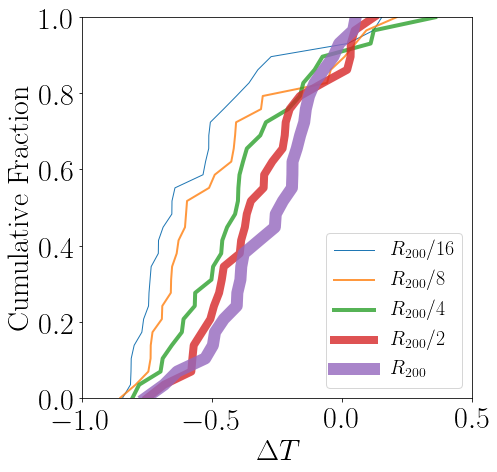

In [265]:
plt.figure(figsize=(7,7))

plt.plot(np.sort(delta_T[:,0]), np.linspace(0,1,30), label=r'$R_{200}/16$', linewidth=1)
plt.plot(np.sort(delta_T[:,1]), np.linspace(0,1,30), label=r'$R_{200}/8$', linewidth=2, alpha=0.8)
plt.plot(np.sort(delta_T[:,2]), np.linspace(0,1,30), label=r'$R_{200}/4$', linewidth=4, alpha=0.8)
plt.plot(np.sort(delta_T[:,3]), np.linspace(0,1,30), label=r'$R_{200}/2$', linewidth=8, alpha=0.8)
plt.plot(np.sort(delta_T[:,4]), np.linspace(0,1,30), label=r'$R_{200}$', linewidth=12, alpha=0.8)


plt.xlabel(r"$\Delta T$")
plt.ylabel("Cumulative Fraction")
plt.xlim([-1.0,0.5])
plt.ylim([0,1])
plt.legend(fontsize=20)
plt.savefig("../Document/delta_triaxiality_distro.pdf", bbox_inches='tight')

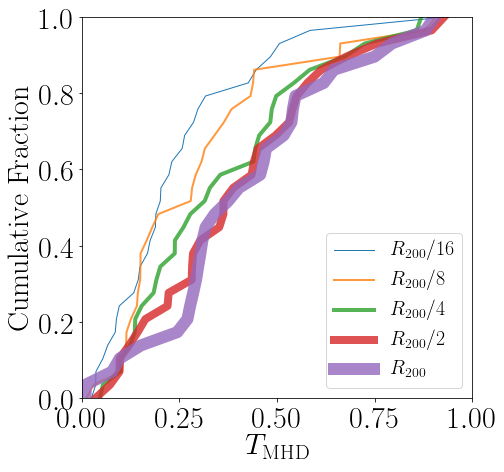

In [264]:
plt.figure(figsize=(7,7))

plt.plot(np.sort(T_MHD[:,0]), np.linspace(0,1,30), label=r'$R_{200}/16$', linewidth=1)
plt.plot(np.sort(T_MHD[:,1]), np.linspace(0,1,30), label=r'$R_{200}/8$', linewidth=2, alpha=0.8)
plt.plot(np.sort(T_MHD[:,2]), np.linspace(0,1,30), label=r'$R_{200}/4$', linewidth=4, alpha=0.8)
plt.plot(np.sort(T_MHD[:,3]), np.linspace(0,1,30), label=r'$R_{200}/2$', linewidth=8, alpha=0.8)
plt.plot(np.sort(T_MHD[:,4]), np.linspace(0,1,30), label=r'$R_{200}$', linewidth=12, alpha=0.8)


plt.xlabel(r"$T_{\rm MHD}$")
plt.ylabel("Cumulative Fraction")
plt.xlim([0,1.0])
plt.ylim([0,1])
plt.legend(fontsize=20)
plt.savefig("../Document/triaxialiy_distro_MHD.pdf", bbox_inches='tight')

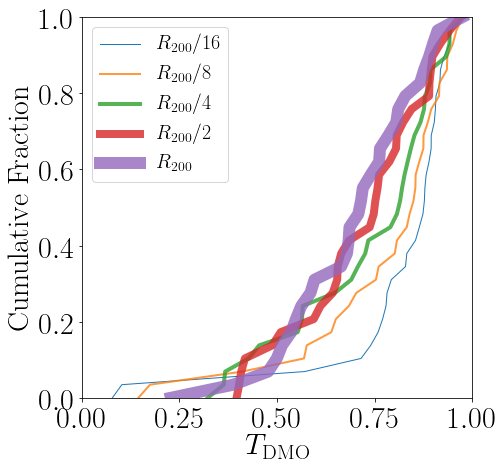

In [263]:
plt.figure(figsize=(7,7))

plt.plot(np.sort(T_DM[:,0]), np.linspace(0,1,30), label=r'$R_{200}/16$', linewidth=1)
plt.plot(np.sort(T_DM[:,1]), np.linspace(0,1,30), label=r'$R_{200}/8$', linewidth=2, alpha=0.8)
plt.plot(np.sort(T_DM[:,2]), np.linspace(0,1,30), label=r'$R_{200}/4$', linewidth=4, alpha=0.8)
plt.plot(np.sort(T_DM[:,3]), np.linspace(0,1,30), label=r'$R_{200}/2$', linewidth=8, alpha=0.8)
plt.plot(np.sort(T_DM[:,4]), np.linspace(0,1,30), label=r'$R_{200}$', linewidth=12, alpha=0.8)


plt.xlabel(r"$T_{\rm DMO}$")
plt.ylabel("Cumulative Fraction")
plt.xlim([0,1.0])
plt.ylim([0,1])
plt.legend(fontsize=20)
plt.savefig("../Document/triaxialiy_distro_DM.pdf", bbox_inches='tight')

In [144]:
disk_properties = np.loadtxt("../Data/Halo_General/Level 4/level4_disk_properties.txt")
satellite_properties = np.loadtxt("../Data/Halo_General/Level 4/level4_satellite_properties.txt")#,encoding = 'utf-8')
bfield_properties = np.loadtxt("../Data/Halo_General/Level 4/level4_bfield_properties.txt")
params = np.loadtxt("../data/Halo_General/Level 4/level4_params.txt", delimiter=',')

compiled_properties = np.ones((30,4))
main_props = dict()
main_props['rho_gas'] = bfield_properties[:,3]
main_props['D/T'] = disk_properties[:,9]
main_props['R_opt'] = disk_properties[:,10]
main_props['f_acc'] = disk_properties[:,11]

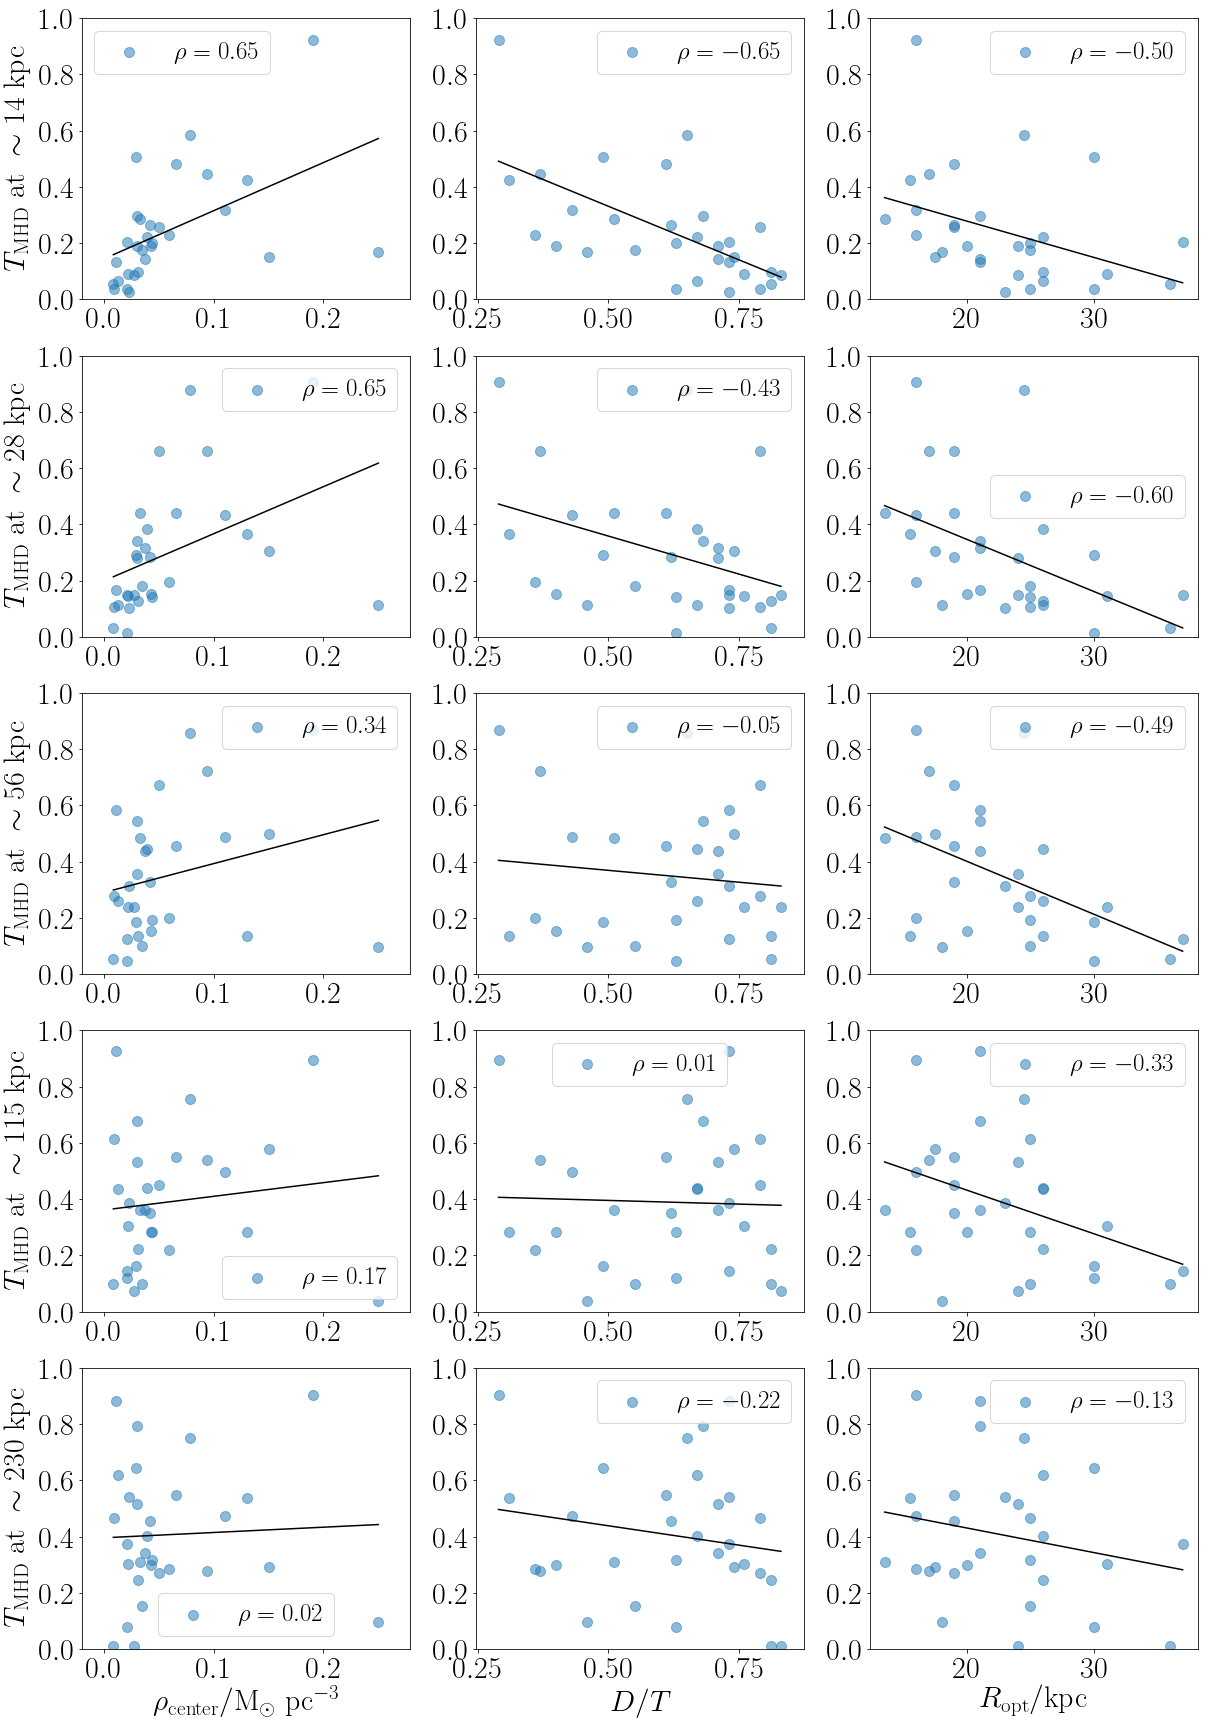

In [266]:
xlabel = dict()
xlabel[1] = r"$\rho_{\mathrm {center}}/ \mathrm{M}_{\odot}\ \mathrm{pc}^{-3}$"
xlabel[2] = "$D/T$"
xlabel[3] = "${R_{\mathrm{opt}}}/{\mathrm{kpc}}$"
xlabel[4] = "$f_{\mathrm{acc}}$"



i_plot = 0
T_data = T_MHD.copy()
plt.figure(figsize=(20,30))
for i_radius in range(5):
    for i_prop, prop in enumerate(['rho_gas', 'D/T', 'R_opt']):
        i_plot += 1
        plt.subplot(5,3,i_plot)
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(main_props[prop], T_data[:,i_radius])
        r_value, p_values = scipy.stats.spearmanr(main_props[prop], b=T_data[:,i_radius])
        plt.scatter(main_props[prop], T_data[:,i_radius],label=r'$\rho = {:.2f}$'.format(r_value), s=100, alpha=0.5)
        x = np.linspace(main_props[prop].min(), main_props[prop].max(), 20)
        y = slope*x + intercept
        plt.plot(x, y, color='black')
        
        plt.ylim((0,1))
        plt.yticks(np.linspace(0,1,6))
        
        if i_plot > 12:
            plt.xlabel(xlabel[i_prop+1])
        if i_plot==1:
            plt.ylabel(r"$T_{\rm MHD}\ {\rm at}\ \sim 14\ {\rm kpc}$")
        if i_plot==4:
            plt.ylabel(r"$T_{\rm MHD}\ {\rm at}\ \sim 28\ {\rm kpc}$")
        if i_plot==7:
            plt.ylabel(r"$T_{\rm MHD}\ {\rm at}\ \sim 56\ {\rm kpc}$")
        if i_plot==10:
            plt.ylabel(r"$T_{\rm MHD}\ {\rm at}\ \sim 115\ {\rm kpc}$")
        if i_plot==13:
            plt.ylabel(r"$T_{\rm MHD}\ {\rm at}\ \sim 230\ {\rm kpc}$")

        plt.legend(fontsize=25)

plt.savefig('../Document/correlation_T_MHD_disk.pdf', bbox_inches='tight')

In [247]:
print(np.mean(disk_properties[:,2]), np.std(disk_properties[:,2]))
print(np.mean(Rvir200['MHD']), np.std(Rvir200['MHD']))
print(np.mean(Rvir200['DM']), np.std(Rvir200['DM']))

230.055 14.974481794038818
205.58660000000006 13.394869529288695
206.50196666666668 13.28876632970704
